# This Notebook Perform two things...........

# 1 Section:                                                                 
Research Area Subject Area Prediction (Large Scale classification) using shallow Multi-Layer Perceptron (MLP) model

# 2 Section:
Research Paper Recommendation for reading: using sentence transformer model

Research Papers dataset link::
https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts/data


# 1 Section:                                                                 

# Loading tools and dataset

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval
# is used for safely evaluating strings containing Python literals or container displays
# (e.g., lists, dictionaries) to their corresponding Python objects.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

2025-10-27 14:32:41.318897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761575561.569079      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761575561.641041      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
arxiv_data = pd.read_csv("/kaggle/input/arxiv-paper-abstracts/arxiv_data_210930-054931.csv")

In [3]:
arxiv_data.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


# Data Cleaning and Preprocessing

In [4]:
arxiv_data.shape

(56181, 3)

In [5]:
arxiv_data.isnull().sum()

terms        0
titles       0
abstracts    0
dtype: int64

In [6]:
arxiv_data.duplicated().sum()

15054

In [7]:
# getting unique labels
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("lenght :",len(labels))

labels : ['cs.LG' 'cs.AI' 'cs.CR' ... 'D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3'
 '68T07, 68T45, 68T10, 68T50, 68U35' 'I.2.0; G.3']
lenght : 1177


In [8]:
# remove duplicate entries based on the "titles" (terms) column
# This filters the DataFrame, keeping only the rows where the titles are not duplicated.
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data['terms'].value_counts()==1))
# how many unique terms
print(arxiv_data['terms'].nunique())

There are 41105 rows in the deduplicated dataset.
2503
3401


In [9]:
# Filtering the rare terms. (it keeps only those rows where the "terms" value occurs more than once in the original DataFrame.)
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(38602, 3)

In [10]:
# It evaluates the given string containing a Python literal or container display (e.g., a list or dictionary) and returns the corresponding Python object.
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.LG']), list(['cs.LG', 'cs.AI']),
       list(['cs.LG', 'cs.CR', 'stat.ML'])], dtype=object)

# train and test split.

In [11]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 34741
Number of rows in validation set: 1930
Number of rows in test set: 1931


In [12]:
# creates a TensorFlow RaggedTensor (terms) from the values in the "terms" column of the train_df DataFrame. A RaggedTensor is a tensor with non-uniform shapes
terms = tf.ragged.constant(train_df['terms'].values)
# This line creates a StringLookup layer in TensorFlow. The purpose of this layer is to map strings to integer indices and vice versa. The output_mode="multi_hot" indicates that the layer will output a multi-hot encoded representation of the input strings.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
# This step adapts the StringLookup layer to the unique values in the "terms" column, building the vocabulary.
lookup.adapt(terms)
# retrieve vocabulary
vocab = lookup.get_vocabulary()

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.GR', 'cs.CR', 'math.OC', 'eess.SP', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'eess.SY', 'cs.MA', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'stat.AP', 'cs.CY', 'stat.ME', 'stat.TH', 'math.ST', 'eess.AS', 'cs.SD', 'cs.DS', 'q-bio.QM', 'q-bio.NC', 'cs.CG', 'stat.CO', 'cs.NI', 'cs.GT', 'math.NA', 'cs.SE', 'cs.NA', 'I.2.6', 'physics.chem-ph', 'cs.DB', 'physics.comp-ph', 'cond-mat.dis-nn', 'q-bio.BM', 'math.PR', 'cs.PL', 'cs.LO', '68T45', 'cs.AR', 'physics.data-an', 'quant-ph', 'I.2.10', 'cs.CE', 'cond-mat.stat-mech', 'q-fin.ST', 'math.DS', 'I.4.6', 'cs.CC', '68T05', 'physics.ao-ph', 'physics.soc-ph', 'physics.med-ph', 'cs.PF', 'econ.EM', 'cs.DM', 'I.4.8', 'q-bio.GN', 'astro-ph.IM', 'physics.flu-dyn', 'math.AT', 'hep-ex', 'I.4', '68U10', 'q-fin.TR', 'physics.geo-ph', 'cs.FL', 'I.5.4', 'I.2', 'cond-mat.mtrl-sci', 'I.4.9', '68T10', 'physics.optics', 'I.4; I.5', '68T07', 'q-fin.CP', 'math.AP', 'I.2.6; 

I0000 00:00:1761575582.254660      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761575582.255353      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [13]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG']
Label-binarized representation: [[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [14]:
# following lines::
# which is used for automatic adjustment of resource usage by TensorFlow's data loading pipeline.

#max_seqlen: Maximum sequence length. It indicates the maximum length allowed for sequences.
max_seqlen = 150
#batch_size: Batch size. It specifies the number of samples to use in each iteration.
batch_size = 128
#padding_token: A token used for padding sequences.
padding_token = "<pad>"
#auto = tf.data.AUTOTUNE: auto is assigned the value tf.data.AUTOTUNE,
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    # creating sequences of labesls
    labels = tf.ragged.constant(dataframe["terms"].values)
    #This line uses the previously defined lookup layer to convert the ragged tensor of labels into a binarized representation. The resulting label_binarized is a NumPy array.
    label_binarized = lookup(labels).numpy()
    # creating sequences of text.
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["abstracts"].values, label_binarized))
    # shuffling data basis on condition
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

"""
In summary, the make_dataset function is designed to create a 
dataset suitable for training a model. It takes a dataframe as input, 
assumes it has "abstracts" and "terms" columns, and creates a dataset of 
batches where each batch consists of abstract 
sequences and their corresponding binarized label sequences. 
"""

'\nIn summary, the make_dataset function is designed to create a \ndataset suitable for training a model. It takes a dataframe as input, \nassumes it has "abstracts" and "terms" columns, and creates a dataset of \nbatches where each batch consists of abstract \nsequences and their corresponding binarized label sequences. \n'

In [15]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [16]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [17]:
# This code snippet is iterating through batches of the training dataset and printing the abstract text along with the corresponding labels.
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b"In recent years, there has been a rapidly expanding focus on explaining the\npredictions made by black-box AI systems that handle image and tabular data.\nHowever, considerably less attention has been paid to explaining the\npredictions of opaque AI systems handling time series data. In this paper, we\nadvance a novel model-agnostic, case-based technique -- Native Guide -- that\ngenerates counterfactual explanations for time series classifiers. Given a\nquery time series, $T_{q}$, for which a black-box classification system\npredicts class, $c$, a counterfactual time series explanation shows how $T_{q}$\ncould change, such that the system predicts an alternative class, $c'$. The\nproposed instance-based technique adapts existing counterfactual instances in\nthe case-base by highlighting and modifying discriminative areas of the time\nseries that underlie the classification. Quantitative and qualitative results\nfrom two comparative experiments indicate that Native Guide gen

In [18]:
# This code calculates the size of the vocabulary in the "abstracts" column of the train_df DataFrame.

# Creating vocabulary with uniques words
vocabulary = set()
train_df["abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

158942


# Text Vectorization

In [19]:
# Initializes a TextVectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size,ngrams=2,output_mode="tf_idf")
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [20]:
"""
Mapping Vectorization to Datasets: The code maps the text vectorization operation to 
each element of the training, validation, and test datasets. This ensures that the text
data in each dataset is transformed into numerical vectors using the adapted TextVectorization layer.
The num_parallel_calls parameter is used to parallelize the mapping process, and prefetch is 
applied to prefetch data batches 
for better performance.
"""
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

# model training

In [21]:
# !pip install tensorflow==2.16.2 keras==3.3.3

In [22]:
# creating shallow_mlp_model  (MLP)
from tensorflow.keras.callbacks import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])

Epoch 1/20


I0000 00:00:1761575655.680380      98 service.cc:148] XLA service 0x7a5bec05b3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761575655.681550      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761575655.681580      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761575656.062776      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/272 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - binary_accuracy: 0.5277 - loss: 0.8778

I0000 00:00:1761575658.364206      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


272/272 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - binary_accuracy: 0.9451 - loss: 0.1266 - val_binary_accuracy: 0.9946 - val_loss: 0.0185
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - binary_accuracy: 0.9947 - loss: 0.0188 - val_binary_accuracy: 0.9946 - val_loss: 0.0190
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - binary_accuracy: 0.9958 - loss: 0.0140 - val_binary_accuracy: 0.9946 - val_loss: 0.0191
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - binary_accuracy: 0.9965 - loss: 0.0114 - val_binary_accuracy: 0.9946 - val_loss: 0.0194
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - binary_accuracy: 0.9970 - loss: 0.0097 - val_binary_accuracy: 0.9944 - val_loss: 0.0202
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - binary_accuracy: 0.9974 - loss: 0.0085 - val_binary_accuracy: 0.9945 - val_loss: 0.0203


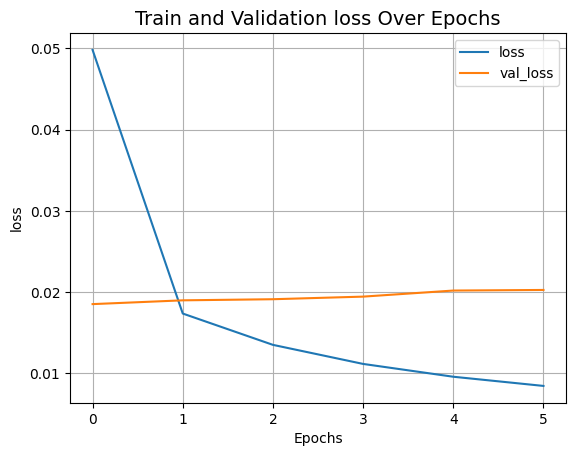

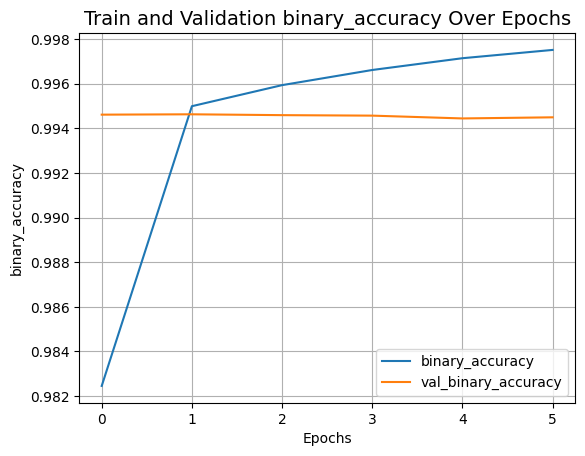

In [23]:
# plotting loss
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

# Model Evaluation

In [24]:
# model evaltuation on test and val dataset
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - binary_accuracy: 0.9946 - loss: 0.0187
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - binary_accuracy: 0.9945 - loss: 0.0188
Categorical accuracy on the test set: 99.46%.
Categorical accuracy on the validation set: 99.46%.


# Save Model and Text Vectorizer:

In [25]:
# Save Model and Text Vectorizer
import pickle
import os
import numpy as np

import os

# Create directory
os.makedirs("/kaggle/working/models", exist_ok=True)

# Save the trained model
model1.save("/kaggle/working/models/model.h5")

# Save the configuration of the text vectorizer
saved_text_vectorizer_config = text_vectorizer.get_config()
with open("models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_config, f)

# Save ALL text vectorizer weights (this includes IDF weights)
text_vectorizer_weights = text_vectorizer.get_weights()
with open("models/text_vectorizer_weights.pkl", "wb") as f:
    pickle.dump(text_vectorizer_weights, f)

# Save the vocabulary
with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

print("All files saved successfully!")
print(f"Number of weight arrays saved: {len(text_vectorizer_weights)}")


All files saved successfully!
Number of weight arrays saved: 0


# Load Model and Text Vectorizer:

In [26]:
from tensorflow import keras
import pickle
import numpy as np

# Load the model
loaded_model = keras.models.load_model("models/model.h5")
print("Model loaded successfully")

# Load vocabulary
with open("models/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

print(f"Vocabulary size: {len(vocab)}")

# Use the ORIGINAL text_vectorizer from training (it's still in memory)
loaded_text_vectorizer = text_vectorizer
print("Using original text vectorizer from training")

print("All components ready!")

Model loaded successfully
Vocabulary size: 165
Using original text vectorizer from training
All components ready!


In [27]:
# Load the vocabulary
with open("models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)

# Model Prediction

In [28]:
def predict_category(abstract, model, vectorizer, label_lookup):
    # Preprocess the abstract
    preprocessed_abstract = vectorizer([abstract])
    
    # Make predictions
    predictions = model.predict(preprocessed_abstract, verbose=0)
    
    # Convert predictions to binary (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)
    
    # Convert to labels
    predicted_labels = label_lookup(binary_predictions[0])
    
    return predicted_labels

In [29]:
# Example usage
new_abstract = "Graph neural networks (GNNs) have been widely used to learn vector\nrepresentation of graph-structured data and achieved better task performance\nthan conventional methods. The foundation of GNNs is the message passing\nprocedure, which propagates the information in a node to its neighbors. Since\nthis procedure proceeds one step per layer, the range of the information\npropagation among nodes is small in the lower layers, and it expands toward the\nhigher layers. Therefore, a GNN model has to be deep enough to capture global\nstructural information in a graph. On the other hand, it is known that deep GNN\nmodels suffer from performance degradation because they lose nodes' local\ninformation, which would be essential for good model performance, through many\nmessage passing steps. In this study, we propose multi-level attention pooling\n(MLAP) for graph-level classification tasks, which can adapt to both local and\nglobal structural information in a graph. It has an attention pooling layer for\neach message passing step and computes the final graph representation by\nunifying the layer-wise graph representations. The MLAP architecture allows\nmodels to utilize the structural information of graphs with multiple levels of\nlocalities because it preserves layer-wise information before losing them due\nto oversmoothing. Results of our experiments show that the MLAP architecture\nimproves the graph classification performance compared to the baseline\narchitectures. In addition, analyses on the layer-wise graph representations\nsuggest that aggregating information from multiple levels of localities indeed\nhas the potential to improve the discriminability of learned graph\nrepresentations."
predicted_categories = predict_category(new_abstract, loaded_model, loaded_text_vectorizer, invert_multi_hot)
print("Predicted Categories:", predicted_categories)

Predicted Categories: ['cs.CV' 'cs.LG']


In [30]:
# Example usage
new_abstract = 'Deep networks and decision forests (such as random forests and gradient\nboosted trees) are the leading machine learning methods for structured and\ntabular data, respectively. Many papers have empirically compared large numbers\nof classifiers on one or two different domains (e.g., on 100 different tabular\ndata settings). However, a careful conceptual and empirical comparison of these\ntwo strategies using the most contemporary best practices has yet to be\nperformed. Conceptually, we illustrate that both can be profitably viewed as\n"partition and vote" schemes. Specifically, the representation space that they\nboth learn is a partitioning of feature space into a union of convex polytopes.\nFor inference, each decides on the basis of votes from the activated nodes.\nThis formulation allows for a unified basic understanding of the relationship\nbetween these methods. Empirically, we compare these two strategies on hundreds\nof tabular data settings, as well as several vision and auditory settings. Our\nfocus is on datasets with at most 10,000 samples, which represent a large\nfraction of scientific and biomedical datasets. In general, we found forests to\nexcel at tabular and structured data (vision and audition) with small sample\nsizes, whereas deep nets performed better on structured data with larger sample\nsizes. This suggests that further gains in both scenarios may be realized via\nfurther combining aspects of forests and networks. We will continue revising\nthis technical report in the coming months with updated results.'
predicted_categories = predict_category(new_abstract, loaded_model, loaded_text_vectorizer, invert_multi_hot)
print("Predicted Categories:", predicted_categories)

Predicted Categories: ['cs.LG' 'stat.ML']


In [31]:
# great resutls...................................

# =======Section 2========

# 2 Recommendation System

In [32]:
arxiv_data.drop(columns = ["terms","abstracts"], inplace = True)

In [33]:
arxiv_data.drop_duplicates(inplace= True)
arxiv_data.reset_index(drop= True,inplace = True)

In [34]:
pd.set_option('display.max_colwidth', None)
arxiv_data

,titles
0,Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
1,Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
2,Power up! Robust Graph Convolutional Network via Graph Powering
3,Releasing Graph Neural Networks with Differential Privacy Guarantees
4,Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
...,...
41100,An experimental study of graph-based semi-supervised classification with additional node information
41101,Bayesian Differential Privacy through Posterior Sampling
41102,Mining Spatio-temporal Data on Industrialization from Historical Registries
41103,Wav2Letter: an End-to-End ConvNet-based Speech Recognition System


# Sentence Transformers

In [35]:
# !pip install transformers==4.44.0 huggingface_hub==0.24.0 sentence-transformers==3.0.1

In [36]:
# # Step 1: Uninstall conflicting packages
# !pip uninstall peft huggingface-hub transformers sentence-transformers -y

In [37]:
# # Step 2: Install compatible versions together
# !pip install tensorflow==2.16.2 keras==3.3.3
# !pip install huggingface-hub==0.23.5
# !pip install peft==0.11.0
# !pip install transformers==4.44.0
# !pip install sentence-transformers==3.0.1

In [38]:
from sentence_transformers import SentenceTransformer
import numpy as np

try:
    print("🔄 Downloading sentence transformer model (this may take a minute)...")
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Remove local_files_only=True to download
    print("✅ Model downloaded and loaded successfully!")
    
    # Generate embeddings
    sentences = arxiv_data['titles'].tolist()
    embeddings = model.encode(sentences)
    print(f"✅ Created embeddings with shape: {embeddings.shape}")
    
except Exception as e:
    print(f"⚠️  SentenceTransformer failed: {e}")
    print("🔄 Falling back to TF-IDF...")
    
    try:
        from sklearn.feature_extraction.text import TfidfVectorizer
        
        # Create TF-IDF vectorizer
        vectorizer = TfidfVectorizer(max_features=1000)
        sentences = arxiv_data['titles'].fillna('').tolist()
        embeddings = vectorizer.fit_transform(sentences).toarray()
        print(f"✅ Created TF-IDF embeddings with shape: {embeddings.shape}")
        
    except Exception as tfidf_error:
        print(f"❌ TF-IDF also failed: {tfidf_error}")
        print("Please make sure 'arxiv_data' is defined and contains 'titles' column")
        embeddings = None


🔄 Downloading sentence transformer model (this may take a minute)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

⚠️  SentenceTransformer failed: 404 Client Error. (Request ID: Root=1-68ff83bc-592b8e8528cf546d665504c5;1b169ce5-0668-4f89-b9a7-933aff3de7f6)

Entry Not Found for url: https://huggingface.co/api/models/sentence-transformers/all-MiniLM-L6-v2/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"
🔄 Falling back to TF-IDF...
✅ Created TF-IDF embeddings with shape: (41105, 1000)


In [39]:
embeddings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Why select all-MiniLM-L6-v2?

All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs. Source

Its small in size 80 MB with good performance.

# Print the embeddings

In [40]:
c = 0
#This loop iterates over pairs of sentences and their corresponding embeddings. 
#zip is used to iterate over both lists simultaneously.
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding length:", len(embedding)) # list of floats
    print("")
    # Breaks out of the loop after printing information for the first 5 sentences.
    if c >=5:
        break
    c +=1 

Sentence: Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
Embedding length: 1000

Sentence: Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
Embedding length: 1000

Sentence: Power up! Robust Graph Convolutional Network via Graph Powering
Embedding length: 1000

Sentence: Releasing Graph Neural Networks with Differential Privacy Guarantees
Embedding length: 1000

Sentence: Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
Embedding length: 1000

Sentence: Lifelong Graph Learning
Embedding length: 1000



# Save files

In [41]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import pickle

print("🔄 Loading sentence transformer model...")

try:
    
    rec_model = SentenceTransformer('all-MiniLM-L6-v2', trust_remote_code=True)
except:
    print("❌ Sentence-BERT failed, using TF-IDF instead...")
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    vectorizer = TfidfVectorizer(max_features=1000)
    sentences = arxiv_data['titles'].fillna('').tolist()
    embeddings = vectorizer.fit_transform(sentences).toarray()
    
    # Save TF-IDF files
    with open('models/embeddings.pkl', 'wb') as f:
        pickle.dump(embeddings, f)
    with open('models/sentences.pkl', 'wb') as f:
        pickle.dump(sentences, f)
    with open('models/vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    
    print("✅ TF-IDF embeddings saved instead")
else:
    # If Sentence-BERT worked, save those files
    sentences = arxiv_data['titles'].fillna('').tolist()
    embeddings = rec_model.encode(sentences, convert_to_tensor=True)
    
    with open('models/embeddings.pkl', 'wb') as f:
        pickle.dump(embeddings, f)
    with open('models/sentences.pkl', 'wb') as f:
        pickle.dump(sentences, f)
    with open('models/rec_model.pkl', 'wb') as f:
        pickle.dump(rec_model, f)
    
    print("✅ Sentence-BERT files saved successfully!")

🔄 Loading sentence transformer model...
❌ Sentence-BERT failed, using TF-IDF instead...
✅ TF-IDF embeddings saved instead


# Recommendation for similar papers

In [42]:
# Load the appropriate models based on what was saved
try:
    # Try to load Sentence-BERT files
    embeddings = pickle.load(open('models/embeddings.pkl','rb'))
    sentences = pickle.load(open('models/sentences.pkl','rb'))
    rec_model = pickle.load(open('models/rec_model.pkl','rb'))
    using_sbert = True
    print("✅ Sentence-BERT models loaded successfully!")
    print(f"📊 Embeddings shape: {embeddings.shape}")
    
except FileNotFoundError:
    # Fallback to TF-IDF
    embeddings = pickle.load(open('models/embeddings.pkl','rb'))
    sentences = pickle.load(open('models/sentences.pkl','rb'))
    vectorizer = pickle.load(open('models/vectorizer.pkl','rb'))
    using_sbert = False
    print("✅ TF-IDF models loaded successfully!")
    print(f"📊 Embeddings shape: {embeddings.shape}")

print(f"📝 Number of papers: {len(sentences)}")
print(f"🔧 Using: {'Sentence-BERT' if using_sbert else 'TF-IDF'}")

✅ TF-IDF models loaded successfully!
📊 Embeddings shape: (41105, 1000)
📝 Number of papers: 41105
🔧 Using: TF-IDF


In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import torch
from sentence_transformers import util

def recommendation(input_paper, top_k=5):
    """
    Universal recommendation function that works with both Sentence-BERT and TF-IDF
    """
    if using_sbert:
        # Sentence-BERT approach
        input_embedding = rec_model.encode(input_paper, convert_to_tensor=True)
        cosine_scores = util.cos_sim(embeddings, input_embedding)
        top_similar_papers = torch.topk(cosine_scores, dim=0, k=top_k, sorted=True)
        
        papers_list = []
        for i in top_similar_papers.indices:
            papers_list.append(sentences[i.item()])
            
    else:
        # TF-IDF approach
        input_embedding = vectorizer.transform([input_paper]).toarray()
        similarities = cosine_similarity(input_embedding, embeddings)[0]
        top_indices = similarities.argsort()[-top_k:][::-1]
        
        papers_list = []
        for idx in top_indices:
            papers_list.append(sentences[idx])
    
    return papers_list

In [44]:
# Example usage 1: (use this paper as input (Attention is All you Need))
input_paper = input("Enter the title of any paper you like: ").strip()

if not input_paper:
    input_paper = "Attention is All You Need"
    print(f"Using default paper: '{input_paper}'")

recommend_papers = recommendation(input_paper)

print(f"\n📚 We recommend these papers similar to: '{input_paper}'")
print("=" * 60)
for i, paper in enumerate(recommend_papers, 1):
    print(f"{i}. {paper}")

Enter the title of any paper you like:  Attention is All you Need



📚 We recommend these papers similar to: 'Attention is All you Need'
1. 15 Keypoints Is All You Need
2. Segmentation is All You Need
3. Categorical Representation Learning: Morphism is All You Need
4. MemGEN: Memory is All You Need
5. One Epoch Is All You Need


In [45]:
# Example usage 2: (use this paper as input (BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding))
input_paper = input("Enter the title of any paper you like: ").strip()

if not input_paper:
    input_paper = "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"
    print(f"Using default paper: '{input_paper}'")

recommend_papers = recommendation(input_paper)

print(f"\n📚 We recommend these papers similar to: '{input_paper}'")
print("=" * 60)
for i, paper in enumerate(recommend_papers, 1):
    print(f"{i}. {paper}")

Enter the title of any paper you like:  BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding



📚 We recommend these papers similar to: 'BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding'
1. BEiT: BERT Pre-Training of Image Transformers
2. Understanding the Difficulty of Training Transformers
3. UniVL: A Unified Video and Language Pre-Training Model for Multimodal Understanding and Generation
4. CUPID: Adaptive Curation of Pre-training Data for Video-and-Language Representation Learning
5. PointContrast: Unsupervised Pre-training for 3D Point Cloud Understanding


In [46]:
# Example usage 3: (use this paper as input (Review of deep learning: concepts, CNN architectures, challenges, applications, future directions))
input_paper = input("Enter the title of any paper you like: ").strip()

if not input_paper:
    input_paper = "Review of deep learning: concepts, CNN architectures, challenges, applications, future directions"
    print(f"Using default paper: '{input_paper}'")

recommend_papers = recommendation(input_paper)

print(f"\n📚 We recommend these papers similar to: '{input_paper}'")
print("=" * 60)
for i, paper in enumerate(recommend_papers, 1):
    print(f"{i}. {paper}")

Enter the title of any paper you like:  Review of deep learning: concepts, CNN architectures, challenges, applications, future directions



📚 We recommend these papers similar to: 'Review of deep learning: concepts, CNN architectures, challenges, applications, future directions'
1. A Review of Deep Learning with Special Emphasis on Architectures, Applications and Recent Trends
2. A Review of Uncertainty Quantification in Deep Learning: Techniques, Applications and Challenges
3. Deep Reinforcement Learning for Multi-Agent Systems: A Review of Challenges, Solutions and Applications
4. Graph-based Facial Affect Analysis: A Review of Methods, Applications and Challenges
5. Review of Deep Learning


In [47]:
# install this versions
import sentence_transformers
import tensorflow
import torch
print(torch.__version__)
print(sentence_transformers.__version__)
print(tensorflow.__version__)

2.6.0+cu124
4.1.0
2.18.0
